# Individual Video Analytics: user level

First, we specify course name, video name, and subset of data (all, on-campus = WEBAUTH, or distant learning = ONECE) that we want to process.

In [81]:
#coursename = 'CS229'
#videoname = 'CS22922Sep2014'
#coursename = 'CS107_ClassX'
#videoname = 'CS10706Jan2014_Introduction_to_C_Nuances'
#videoname = 'CS10707Feb2014_Load_Effective_Address_and_Move_abuses'
#videoname = 'CS10721Feb2014_Compilation_Tool_Chain'
coursename = 'CS110_ClassX'
#videoname = 'CS11002Apr2014_Copying_in_Unix'
#videoname = 'CS11002Apr2014_Unix_Builtins'
videoname = 'CS11002Apr2014_Full'
subset = 'all' # choose of 'all', 'WEBAUTH' or 'ONECE'

Here we import package for data analysis called 'pandas' and specify directories.

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import datetime
import math

In [83]:
%matplotlib inline
#Main directory contains data (this is my local machine)
#mainDir = 'C:/Users/Tee/Documents/Active/EducationProject/SEOL/VideoAnalytics/main' #(Tee's ICME local machine)
mainDir = 'C:/Users/Admin/Dropbox/Active/EducationProject/SEOL/VideoAnalytics/main' #(Tee's dropbox machine)
#Here are directories that we will work with
OutputBigDirectory = mainDir + '/output/big/'+ coursename +'/'+ videoname 
OutputSmallDirectory = mainDir + '/output/small/'+ coursename +'/'+ videoname +'/' + subset
if not os.path.exists(OutputSmallDirectory):
    os.makedirs(OutputSmallDirectory)

Pull corresponding CSV files up and important parameters in need.

In [84]:
CleanData = pd.read_csv(OutputBigDirectory+"/CleanData.csv")
CleanSessionSummary = pd.read_csv(OutputBigDirectory+"/CleanSessionSummary.csv")
CleaningSummary = pd.read_csv(mainDir + '/output/small/'+ coursename +'/'+ videoname +"/CleaningSummary.csv")
MaxSecondMarker = int(CleaningSummary.iloc[4,1])
MaxMinuteMarker = int(CleaningSummary.iloc[5,1])

In [85]:
[MaxSecondMarker, MaxMinuteMarker]

[2926, 48]

Select data to analyze according to subset.

In [86]:
if subset == 'WEBAUTH':
    CleanData = CleanData[CleanData.UserType=='WEBAUTH']
    CleanSessionSummary = CleanSessionSummary[CleanSessionSummary.UserType=='WEBAUTH']
if subset == 'ONECE':
    CleanData = CleanData[CleanData.UserType=='ONECE']
    CleanSessionSummary = CleanSessionSummary[CleanSessionSummary.UserType=='ONECE']

We would like to continue our analysis from the previous notebook. So we read individual video summary file.

In [87]:
#Read individual video summary file to continue.
Essential = pd.read_csv(OutputSmallDirectory+"/IndividualVideoSummary_"+subset+".csv")

## Analysis at user level: viewership

Now we would like to discuss another way of representing video watching over video timeline. One can create a viewership matrix $V$ where each row corresponds to a user, and each column responds to a second in video. The entry $(i,j)$ is number of counts by a user $i$ at video second $j$. We can define similar viewership matrix for the first time the user watches video.

In [88]:
CleanHashedUserList = list(set(CleanSessionSummary.HashedUser))
WatchData = CleanData[CleanData.StepType=='Watch']
VbyUser = np.zeros((len(CleanHashedUserList),MaxSecondMarker+1))
VFirstTime = np.zeros((len(CleanHashedUserList),MaxSecondMarker+1))
for i in range(0,len(CleanHashedUserList)):
    d = WatchData[WatchData.HashedUser==CleanHashedUserList[i]]
    df = d[d.SessionNumberByUser==0]
    if d.shape[0]>0:
        for j in range(0,d.shape[0]):
            VbyUser[i,d.EndTime.iloc[j]:(d.EndTime.iloc[j] + d.VideoStepLength.iloc[j])] +=1
    if df.shape[0]>0:
        for j in range(0,df.shape[0]):
            VFirstTime[i,df.EndTime.iloc[j]:(df.EndTime.iloc[j] + df.VideoStepLength.iloc[j])] +=1

One may try to see how many people end up watching most video. We then need to convert $V$ to binary counterpart $W$. Let's look at histogram of fraction of videos watched by users. Here one can see bimodal distribution, while MOOCs tend to have unimodal distribution. This histogram once converted to color map can be used to do cross-video comparision in order to imply video's quality. Note: box plot is not useful due to bimodal nature of data.


[50.0, 25.0]

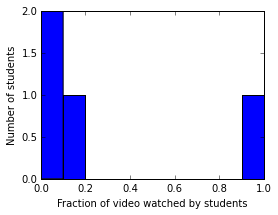

In [89]:
W = pd.DataFrame(data=(VbyUser>0).astype(int),columns=range(0,MaxSecondMarker+1))
WFirstTime = pd.DataFrame(data=(VFirstTime>0).astype(int),columns=range(0,MaxSecondMarker+1))
#setup subplot template for users watch % of video. There will be three subplots
plt.figure(5)
v = W.mean(axis=1) 
l = list(v)
#l = list((VbyUser>0).sum(axis=1)/float(MaxSecondMarker+1))
#plt.hist(l)
plt.hist(l, bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xlabel('Fraction of video watched by students')
plt.ylabel('Number of students')

fig = plt.gcf()
fig.set_size_inches(4,3)
#save figure
filename = '05FractionOfVideosWatched_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

Essential.loc[Essential.shape[0]] = ['number of users in % of users calculation', len(l)]
Essential.loc[Essential.shape[0]] = ['% of users who watch 0-10% of video', len([x for x in l if x < 0.1])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 10-20% of video', len([x for x in l if (x >= 0.1)&(x<0.2)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 20-30% of video', len([x for x in l if (x >= 0.2)&(x<0.3)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 30-40% of video', len([x for x in l if (x >= 0.3)&(x<0.4)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 40-50% of video', len([x for x in l if (x >= 0.4)&(x<0.5)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 50-60% of video', len([x for x in l if (x >= 0.5)&(x<0.6)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 60-70% of video', len([x for x in l if (x >= 0.6)&(x<0.7)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 70-80% of video', len([x for x in l if (x >= 0.7)&(x<0.8)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 80-90% of video', len([x for x in l if (x >= 0.8)&(x<0.9)])/float(len(l))*100]
Essential.loc[Essential.shape[0]] = ['% of users who watch 90-100% of video', len([x for x in l if x >= 0.9])/float(len(l))*100]
# % of video viewed: mean and median
Essential.loc[Essential.shape[0]] = ['% of video viewed: mean', np.mean(l)]
Essential.loc[Essential.shape[0]] = ['% of video viewed: median', np.median(l)]
# skew ratio: ratio of people who watch more than 90% of video and people who watch less than 10% of video.
Essential.loc[Essential.shape[0]] = ['% of video viewed: skew ratio', float(len([x for x in l if x >= 0.9]))/len([x for x in l if x < 0.1])]
#percent of people who watch more than 90% of video vs. percent of people who watch less than 10% of video.
[len([x for x in l if x < 0.1])/float(len(l))*100, len([x for x in l if x >= 0.9])/float(len(l))*100]

We would to get a list of hashed user names corresponding to each bar for further use. 

In [90]:
#add code here (see code in Solar on extracting componentsId)

Now we partition viewership data by % of video watched into 10 groups. First we look at viewership pattern by users in each partition for each second. The visualization tool here is color map. Yellow represents viewership on the first session of the user, while black represents viewership on other sessions. The overlay of both colors represent whole viewership. One can see that some users who has low viewership do not quit watching right away at first minutes of video. Many of them spend some time watching other part of video. Some of them show traces of small jumps to navigate the videos.

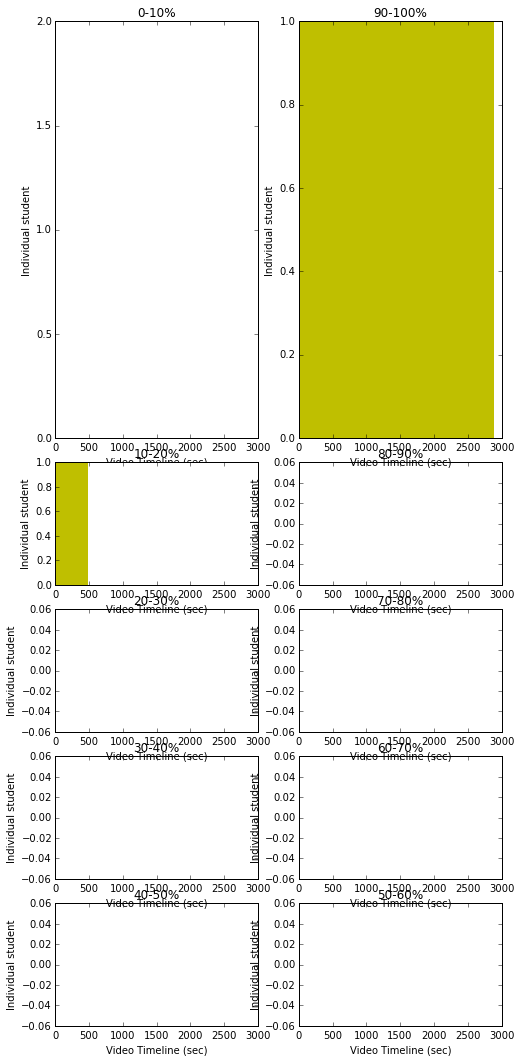

In [91]:
#setup subplot template for viewership pattern. There will be ten subplots
plt.figure(6)

# make a color map of fixed colors
from matplotlib import colors
cmap = colors.ListedColormap(['w', 'black', 'y'])
norm = colors.BoundaryNorm([-1, -0.5, 0.5, 1], cmap.N)

#0-10%
plt.subplot2grid((7,2), (0,0), rowspan=3)
Wselected = W[v<0.1].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[v<0.1].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('0-10%')

#10-20%
plt.subplot2grid((7,2), (3,0))
Wselected = W[(v>0.1)&(v<=0.2)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.1)&(v<=0.2)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('10-20%') 

#20-30%
plt.subplot2grid((7,2), (4,0))
Wselected = W[(v>0.2)&(v<=0.3)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.2)&(v<=0.3)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('20-30%') 

#30-40%
plt.subplot2grid((7,2), (5,0))
Wselected = W[(v>0.3)&(v<=0.4)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.3)&(v<=0.4)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('30-40%') 

#40-50%
plt.subplot2grid((7,2), (6,0))
Wselected = W[(v>0.4)&(v<=0.5)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.4)&(v<=0.5)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('40-50%') 

#50-60%
plt.subplot2grid((7,2), (6,1))
Wselected = W[(v>0.5)&(v<=0.6)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.5)&(v<=0.6)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('50-60%') 

#60-70%
plt.subplot2grid((7,2), (5,1))
Wselected = W[(v>0.6)&(v<=0.7)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.6)&(v<=0.7)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('60-70%') 

#70-80%
plt.subplot2grid((7,2), (4,1))
Wselected = W[(v>0.7)&(v<=0.8)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.7)&(v<=0.8)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('70-80%') 

#80-90%
plt.subplot2grid((7,2), (3,1))
Wselected = W[(v>0.8)&(v<=0.9)].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[(v>0.8)&(v<=0.9)].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('80-90%') 

#90-100%
#plt.subplot(616)
plt.subplot2grid((7,2), (0,1), rowspan=3)
Wselected = W[v>0.9].sort(range(0,MaxSecondMarker+1))
WFselected = WFirstTime[v>0.9].loc[Wselected.index]

plt.pcolor(Wselected + WFselected ,cmap=cmap)
#plt.matshow(Wselected + WFselected,cmap=cmap,aspect='auto')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Individual student')
plt.title('90-100%') 

fig = plt.gcf()
fig.set_size_inches(4*2,3*6)
#save figure
filename = '06ViewershipColormapByGroup_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

Next we look at viewership summary for each group. 

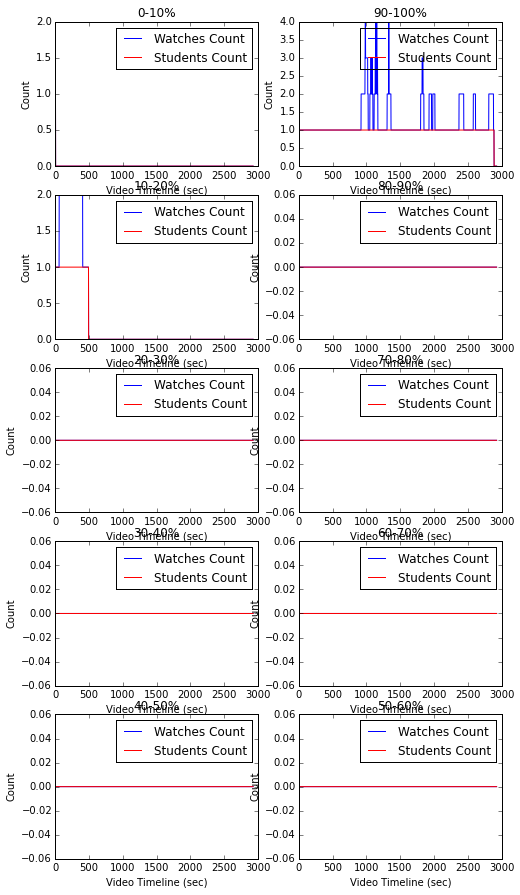

In [92]:
#setup subplot template for viewership pattern. There will be ten subplots
plt.figure(7)

#0-10%
plt.subplot2grid((5,2), (0,0))
Vselected = VbyUser[[i for i, elem in enumerate(v<0.1) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('0-10%') 

#10-20%
plt.subplot2grid((5,2), (1,0))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.1)&(v<=0.2)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('10-20%') 

#20-30%
plt.subplot2grid((5,2), (2,0))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.2)&(v<=0.3)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('20-30%')

#30-40%
plt.subplot2grid((5,2), (3,0))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.3)&(v<=0.4)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('30-40%')

#40-50%
plt.subplot2grid((5,2), (4,0))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.4)&(v<=0.5)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('40-50%')

#50-60%
plt.subplot2grid((5,2), (4,1))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.5)&(v<=0.6)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('50-60%') 

#60-70%
plt.subplot2grid((5,2), (3,1))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.6)&(v<=0.7)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('60-70%') 

#70-80%
plt.subplot2grid((5,2), (2,1))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.7)&(v<=0.8)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('70-80%') 

#80-90%
plt.subplot2grid((5,2), (1,1))
Vselected = VbyUser[[i for i, elem in enumerate((v>0.8)&(v<=0.9)) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('80-90%') 

#90-100%
plt.subplot2grid((5,2), (0,1))
Vselected = VbyUser[[i for i, elem in enumerate(v>0.9) if elem],:]
plt.plot(Vselected.sum(axis=0), c='b',label='Watches Count')
plt.plot((Vselected>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video Timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.title('90-100%') 

fig = plt.gcf()
fig.set_size_inches(4*2,5*3)
#save figure
filename = '07ViewershipSummaryByGroup_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

Finally, one may conclude viewership distributions of each second, i.e., the second is watched by how many users and how many times in total. 

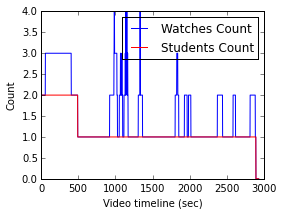

In [93]:
plt.figure(8)
plt.plot(VbyUser.sum(axis=0), c='b',label='Watches Count')
plt.plot((VbyUser>0).sum(axis=0), c='r',label ='Students Count')
plt.xlabel('Video timeline (sec)')
plt.ylabel('Count')
plt.legend(loc='upper right')

fig = plt.gcf()
fig.set_size_inches(4,3)
#save figure
filename = '08ViewershipSummary_'+videoname +'.png'
fig.savefig(os.path.join(OutputSmallDirectory, filename),dpi=100)
fig.show()

Let's summarize what essential information we get from each video and record it.

In [94]:
Essential

,Key,Value
0,Course Name,CS110_ClassX
1,Video Name,CS11002Apr2014_Full
2,Subset,all
3,Pause length: number,21
4,Pause length: mean,2.503011904761905
5,Pause length: 5% tile,0.031233333333333335
6,Pause length: 25% tile,0.16666666666666666
7,Pause length: median,0.4065666666666667
8,Pause length: 75% tile,2.1878333333333333
9,Pause length: 95% tile,10.748


In [95]:
#d = pd.DataFrame({'Info':list(Essential.keys()),'Value':list(Essential.values())})
#d.sort(['Info']).to_csv(OutputSmallDirectory+"/Essential.csv",index=False)
Essential.to_csv(OutputSmallDirectory+"/IndividualVideoSummary_"+subset+".csv",index=False)

## Wrap up

We may combine all code above along with the code from previous notebook to make it as a function of coursename and videoname. Use this in big run.

In [96]:
def IndividualVideoAnalyze( coursename, videoname, subset ):  
    
    #insert all codes above here
    
    print coursename + ":" + videoname + ":" + subset + ": individual video analytics complete. :)"
    return;